## Modeling

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay
from pycaret.classification import setup, compare_models
import lightgbm as lgb
from sklearn.decomposition import PCA

In [2]:
# Load dataset
df = pd.read_parquet('fraud_eda.parquet')
df.head()

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Age,Fault,...,Deductible,DriverRating,Days_Policy_Accident,PastNumberOfClaims,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,NumberOfCars,BasePolicy
0,Dec,Wednesday,Honda,Urban,Tuesday,Jan,Female,Single,21,Policy Holder,...,300,1,30,0,No,No,External,0,3,Liability
1,Jan,Wednesday,Honda,Urban,Monday,Jan,Male,Single,34,Policy Holder,...,400,4,30,0,Yes,No,External,0,1,Collision
2,Oct,Friday,Honda,Urban,Thursday,Nov,Male,Married,47,Policy Holder,...,400,3,30,1,No,No,External,0,1,Collision
3,Jun,Saturday,Toyota,Rural,Friday,Jul,Male,Married,65,Third Party,...,400,2,30,1,Yes,No,External,5,1,Liability
4,Jan,Monday,Honda,Urban,Tuesday,Feb,Female,Single,27,Third Party,...,400,1,30,0,No,No,External,0,1,Collision


In [3]:
df['Age_bins']=pd.cut(df.Age,bins=10,labels=range(1,11), retbins=False,include_lowest=True)

# asign month name to number
m = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
df['Month'] = df['Month'].map(m)
df['MonthClaimed']  = df['MonthClaimed'].map(m)

# # asign week day to number
doc = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].map(doc)
df['DayOfWeek'] = df['DayOfWeek'].map(doc)

make = {'Honda':1, 'Toyota':2, 'Ford':3, 'Mazda':4, 'Chevrolet':5, 'Pontiac':6,
       'Accura':7, 'Dodge':8, 'Mercury':9, 'Jaguar':10, 'Nisson':11, 'VW':12, 'Saab':13,
       'Saturn':14, 'Porche':15, 'BMW':16, 'Mecedes':17, 'Ferrari':18}
df['Make'] = df['Make'].map(make)

df.drop(columns='Age', inplace=True)


In [4]:
# Drop none values
df = df.dropna()

In [5]:
# Seprate Traget variable from data
X= df.drop(columns='FraudFound_P')
y = df['FraudFound_P'] 

In [6]:
df.head()

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Fault,PolicyType,...,DriverRating,Days_Policy_Accident,PastNumberOfClaims,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,NumberOfCars,BasePolicy,Age_bins
0,12,3,1.0,Urban,2,1,Female,Single,Policy Holder,Sport - Liability,...,1,30,0,No,No,External,0,3,Liability,1
1,1,3,1.0,Urban,1,1,Male,Single,Policy Holder,Sport - Collision,...,4,30,0,Yes,No,External,0,1,Collision,3
2,10,5,1.0,Urban,4,11,Male,Married,Policy Holder,Sport - Collision,...,3,30,1,No,No,External,0,1,Collision,5
3,6,6,2.0,Rural,5,7,Male,Married,Third Party,Sedan - Liability,...,2,30,1,Yes,No,External,5,1,Liability,8
4,1,1,1.0,Urban,2,2,Female,Single,Third Party,Sport - Collision,...,1,30,0,No,No,External,0,1,Collision,2


In [7]:
# list of categorical and numerical columns
ohe_col = [  'AccidentArea', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled',
           'WitnessPresent', 'AgentType', 'BasePolicy']

std_col = ['Month','Make','DayOfWeek','DayOfWeekClaimed','VehiclePrice','Deductible', 'DriverRating','Days_Policy_Accident', 'PastNumberOfClaims',
            'NumberOfSuppliments', 'NumberOfCars', 'Age_bins','MonthClaimed']

### Apply One-Hot encoding and Standard scaler by using Column transformer


In [8]:
ct = ColumnTransformer(transformers=[
     ('tnf1',OneHotEncoder(sparse_output=False,drop='first'),ohe_col),
     ('tnf2', StandardScaler(),std_col)], remainder='passthrough')
X= ct.fit_transform(X)

In [9]:
# print new feature names afrer applying one-hot encoding
ohe_col = ct.named_transformers_['tnf1'].get_feature_names_out().tolist()
print(ohe_col)

['AccidentArea_Urban', 'Sex_Male', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow', 'Fault_Third Party', 'PolicyType_Sedan - Collision', 'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils', 'PolicyType_Sport - Collision', 'PolicyType_Sport - Liability', 'PolicyType_Utility - All Perils', 'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'PoliceReportFiled_Yes', 'WitnessPresent_Yes', 'AgentType_Internal', 'BasePolicy_Collision', 'BasePolicy_Liability']


In [10]:
# convert X from array to data frame with new feature names
X = pd.DataFrame(X, columns=[ohe_col+std_col])
print(X.shape, y.shape)
X.head() 

(15044, 34) (15044,)


,AccidentArea_Urban,Sex_Male,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,...,DayOfWeekClaimed,VehiclePrice,Deductible,DriverRating,Days_Policy_Accident,PastNumberOfClaims,NumberOfSuppliments,NumberOfCars,Age_bins,MonthClaimed
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.569257,2.499153,-2.426840,-1.329094,0.086545,-1.162546,-0.886116,4.724453,-1.717882,-1.564204
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.257066,2.499153,-0.177479,1.348195,0.086545,-1.162546,-0.886116,-0.251023,-0.689375,-1.564204
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.806360,2.499153,-0.177479,0.455766,0.086545,-0.370851,-0.886116,-0.251023,0.339132,1.326620
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.494169,-0.575117,-0.177479,-0.436664,0.086545,-0.370851,1.506934,-0.251023,1.881893,0.170290
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.569257,2.499153,-0.177479,-1.329094,0.086545,-1.162546,-0.886116,-0.251023,-1.203628,-1.275122


In [11]:
X[ohe_col].describe()

,AccidentArea_Urban,Sex_Male,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,...,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sport,VehicleCategory_Utility,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,BasePolicy_Collision,BasePolicy_Liability
count,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,...,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000
mean,0.897567,0.839803,0.703470,0.289218,0.002327,0.274262,0.365129,0.321989,0.000931,0.022667,...,0.021869,0.001994,0.001329,0.345653,0.025193,0.027652,0.005584,0.015953,0.389790,0.323385
std,0.303227,0.366801,0.456743,0.453415,0.048179,0.446157,0.481482,0.467254,0.030493,0.148844,...,0.146261,0.044613,0.036438,0.475596,0.156715,0.163980,0.074517,0.125299,0.487719,0.467784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# checking standad deviation
X[std_col].std()

Month                   1.000033
Make                    1.000033
DayOfWeek               1.000033
DayOfWeekClaimed        1.000033
VehiclePrice            1.000033
Deductible              1.000033
DriverRating            1.000033
Days_Policy_Accident    1.000033
PastNumberOfClaims      1.000033
NumberOfSuppliments     1.000033
NumberOfCars            1.000033
Age_bins                1.000033
MonthClaimed            1.000033
dtype: float64

In [13]:
# checking mean
X[std_col].mean()

Month                   1.884309e-15
Make                    1.710499e-16
DayOfWeek               2.656373e-17
DayOfWeekClaimed       -8.265420e-19
VehiclePrice            3.839391e-15
Deductible              4.713024e-16
DriverRating            7.096749e-16
Days_Policy_Accident    5.279555e-16
PastNumberOfClaims     -4.154850e-16
NumberOfSuppliments    -1.043509e-16
NumberOfCars            4.961687e-16
Age_bins                7.835766e-16
MonthClaimed           -5.025582e-15
dtype: float64

### Feature selecting - feature importance from RandomForest

In [14]:
rf = RandomForestClassifier(n_estimators=5,random_state=124)
rf.fit(X,y)

RandomForestClassifier(n_estimators=5, random_state=124)

<AxesSubplot: >

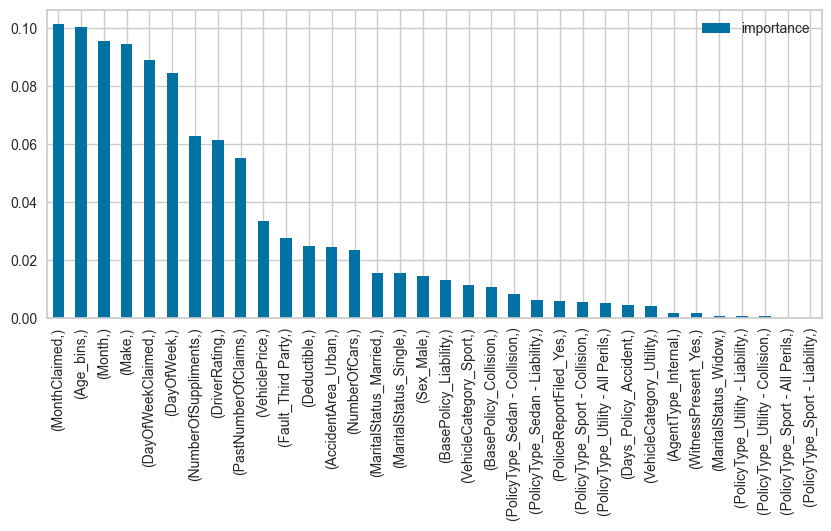

In [15]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=X.columns,columns = ['importance'])
feature_importance.sort_values('importance',ascending=False).plot.bar(figsize=(10,4))

In [16]:
new_features = feature_importance[feature_importance.importance>0].index
feature_importance.sort_values(by ='importance', ascending = False ).head()

,importance
MonthClaimed,0.101240
Age_bins,0.100154
Month,0.095319
Make,0.094279
DayOfWeekClaimed,0.089060


In [17]:
feature_importance[feature_importance>0].count()

importance    33
dtype: int64

### Selecting best features and spliting data into training and testing and validation subsets

In [18]:
# Devide data in to train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.05, random_state=123)
X_train.shape, X_test.shape

((14291, 34), (753, 34))

In [19]:
# target variable is unbalanced classified
y_train.value_counts()

0    13451
1      840
Name: FraudFound_P, dtype: int64

### Over sampling using ADASYN

In [20]:
#Over sampling using imblearn librery
from collections import Counter
# from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN


ada = ADASYN(random_state=43)
X_train_ad, y_train_ad = ada.fit_resample(X_train, y_train)
# X_test, y_test = ada.fit_resample(X_test, y_test)
print('Resampled dataset shape %s' % Counter(y_train_ad))



Resampled dataset shape Counter({1: 13477, 0: 13451})


### Modeling

### Compair models


In [21]:
data = pd.concat([X_train_ad, y_train_ad],axis=1)
data2= pd.concat([X_test, y_test],axis=1)
data_com = pd.concat([data,data2],axis =0)

In [22]:
setup(data, target='FraudFound_P', session_id=123)


,Description,Value
0,Session id,123
1,Target,FraudFound_P
2,Target type,Binary
3,Original data shape,"(26928, 35)"
4,Transformed data shape,"(26928, 35)"
5,Transformed train set shape,"(18849, 35)"
6,Transformed test set shape,"(8079, 35)"
7,Numeric features,34
8,Preprocess,True
9,Imputation type,simple


In [23]:
best_model_com = compare_models()

Extra Trees Classifier model may be the best model for this dataset 


Model Creation:
We will test several model and choose the one with the best performance:

Models: Logistic Regression - SVM - Gradient Boosting - KNN- RandomForest - Extra trees classifier.


In [24]:
log_model = LogisticRegression(max_iter=1000)
kn_model = KNeighborsClassifier()
svc = SVC()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
etc = ExtraTreesClassifier()

models = [log_model, kn_model, svc, gb, rf, etc ]


In [25]:
for model in models:
     model.fit(X_train_ad,y_train_ad)
     y_pred = model.predict(X_test)

     print('Accuracy score for ', model, 'is', accuracy_score(y_test, y_pred))
     print('Precision score is', precision_score(y_test, y_pred))
     print(confusion_matrix(y_test, y_pred))
     print(classification_report(y_pred, y_test))
     print(40*'-')

Accuracy score for  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) is 0.6640106241699867
Precision score is 0.13541666666666666
[[461 249]
 [  4  39]]
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       465
           1       0.91      0.14      0.24       288

    accuracy                           0.66       753
   macro avg       0.78      0.56      0.51       753
weighted avg       0.75      0.66      0.57       753

----------------------------------------
Accuracy score for  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='unif

While the accuracy scores of the models are satisfactory, since this is a classification problem, our focus should be on enhancing the precision score.

### PCA method for feature reduction

In [26]:
X.shape, y.shape

((15044, 34), (15044,))

Plot the cumulative variance ratio with number of components.

In [27]:
data_pca = PCA().fit(X)
variance = data_pca.explained_variance_ratio_.cumsum()

Text(0.5, 1.0, 'Cumulative variance ratio explained by PCA components for summary statistics')

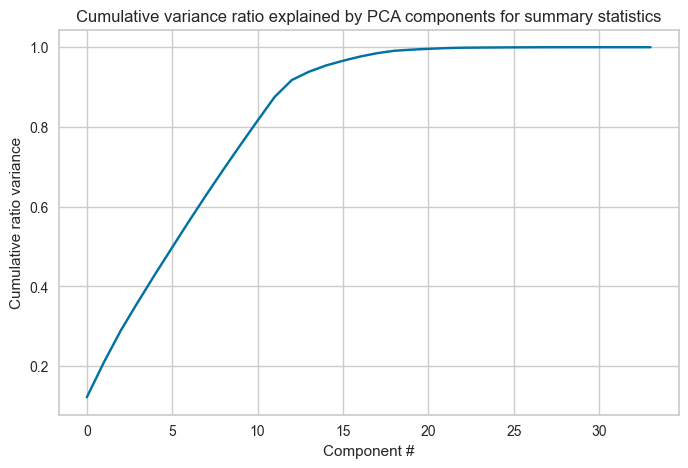

In [28]:
plt.subplots(figsize=(8, 5))
plt.plot(data_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for summary statistics')

The first thirteen components seem to account for over 95% of the variance.

In [29]:
# Over sampling using imblearn librery

ada = ADASYN(random_state=43)
X_new, y_new = ada.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_new))



Resampled dataset shape Counter({0: 14161, 1: 14117})


In [30]:
# Devide data in to train and test
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=123)
X_train.shape, X_test.shape

((22622, 34), (5656, 34))

In [31]:
pca = PCA(n_components=13)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [32]:
# Modeling

svc = SVC()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()


In [33]:
clfs = {
    'SVC' : svc,
    'KN' : knc,  
    'RF': rfc, 
    'ETC': etc,
}

In [34]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    confusion_m = confusion_matrix(y_test, y_pred)
    classification_rpt = classification_report(y_test, y_pred)
    
    return accuracy, precision, confusion_m, classification_rpt

In [35]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy, current_precision, confusion_m, classification_rpt= train_classifier(clf, X_train_pca,y_train,X_test_pca,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print(classification_rpt)
    print(40*'-')
    print(confusion_m)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.791018387553041
Precision -  0.726134149735597
              precision    recall  f1-score   support

           0       0.90      0.65      0.76      2849
           1       0.73      0.93      0.82      2807

    accuracy                           0.79      5656
   macro avg       0.82      0.79      0.79      5656
weighted avg       0.82      0.79      0.79      5656

----------------------------------------
[[1865  984]
 [ 198 2609]]
For  KN
Accuracy -  0.8642149929278642
Precision -  0.7851748251748252
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      2849
           1       0.79      1.00      0.88      2807

    accuracy                           0.86      5656
   macro avg       0.89      0.87      0.86      5656
weighted avg       0.89      0.86      0.86      5656

----------------------------------------
[[2081  768]
 [   0 2807]]
For  RF
Accuracy -  0.9441301272984441
Precision -  0.917812814491781

In [36]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
3,ETC,0.966054,0.957008
2,RF,0.944130,0.917813
1,KN,0.864215,0.785175
0,SVC,0.791018,0.726134


### Hyperparameter tuning with Gridsearchcv

In [37]:
# Hyperparameter tuning
model_hyperparameters = {'SVC_hyperparameters': {'C' : [1,5,10]},
                         'KNN_hyperparameters' : {'n_neighbors' : [3,5,7]},
                         'random_forest_hyperparameters' : {'n_estimators' : range(50,200,20), 'max_depth' : [2,4,6,7]},
                         'ETC_hyperparameters': {'n_estimators':range(100,200,20), 'min_samples_split':[2,4,6]}
                         }
models2 = [svc, kn_model, rf, etc ]


In [38]:
result = []
i = 0     
model_keys = list(model_hyperparameters.keys())

for model in models2:
    key = model_keys[i]
    params = model_hyperparameters[key]
    i += 1

    # print(model)
    # print(params)
    # print(30* '-')


    classifier = GridSearchCV(model, params, cv=5)
    classifier.fit(X_train_pca, y_train)
    result.append({
        'model used' : model,
        'highest score' : classifier.best_score_,
        'best hyperparameters' : classifier.best_params_ })
    result_dataframe = pd.DataFrame(result, columns = ['model used','highest score','best hyperparameters'])
    
    

In [39]:
result_dataframe

,model used,highest score,best hyperparameters
0,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.859429,{'C': 10}
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.878481,{'n_neighbors': 3}
2,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.739546,"{'max_depth': 7, 'n_estimators': 130}"
3,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...",0.966228,"{'min_samples_split': 2, 'n_estimators': 180}"


Final_Model_Selection

In [40]:
# Lets apply this parameters models and get classification report
svc = SVC(C=10)
knc = KNeighborsClassifier(n_neighbors=3)
rfc = RandomForestClassifier(max_depth=7, n_estimators=190)
etc = ExtraTreesClassifier(min_samples_split=2,n_estimators=180 )


In [41]:
clfs2 = {
    'SVC' : svc,
    'KN' : knc,  
    'RF': rfc, 
    'ETC': etc,}

For  SVC
Accuracy -  0.8635077793493635
Precision -  0.8020184030869695
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      2849
           1       0.80      0.96      0.88      2807

    accuracy                           0.86      5656
   macro avg       0.88      0.86      0.86      5656
weighted avg       0.88      0.86      0.86      5656



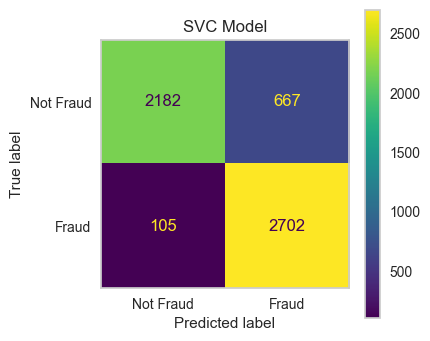

----------------------------------------
For  KN
Accuracy -  0.887906647807638
Precision -  0.8161187081757346
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      2849
           1       0.82      1.00      0.90      2807

    accuracy                           0.89      5656
   macro avg       0.91      0.89      0.89      5656
weighted avg       0.91      0.89      0.89      5656



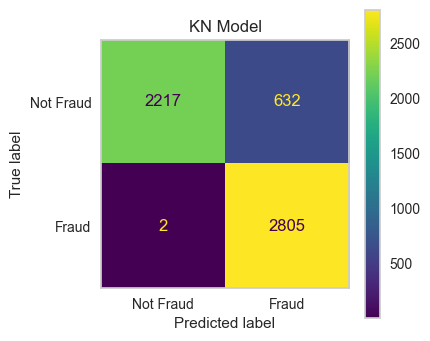

----------------------------------------
For  RF
Accuracy -  0.7422206506364922
Precision -  0.6778275771157395
              precision    recall  f1-score   support

           0       0.87      0.57      0.69      2849
           1       0.68      0.92      0.78      2807

    accuracy                           0.74      5656
   macro avg       0.78      0.74      0.73      5656
weighted avg       0.78      0.74      0.73      5656



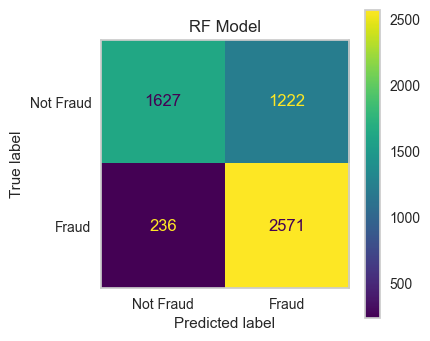

----------------------------------------
For  ETC
Accuracy -  0.9694130127298444
Precision -  0.9598463687150838
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2849
           1       0.96      0.98      0.97      2807

    accuracy                           0.97      5656
   macro avg       0.97      0.97      0.97      5656
weighted avg       0.97      0.97      0.97      5656



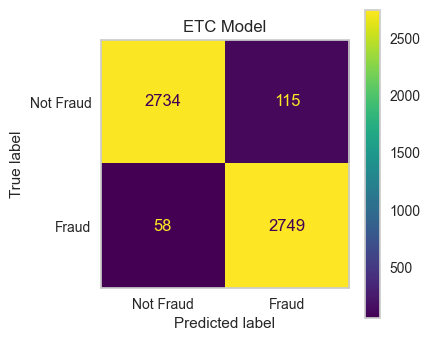

----------------------------------------


In [42]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs2.items():
    
    current_accuracy, current_precision, confusion_m, classification_rpt= train_classifier(clf, X_train_pca,y_train,X_test_pca,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print(classification_rpt)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    
    fig, ax = plt.subplots(figsize=(4,4))
    display_cm = ConfusionMatrixDisplay(confusion_matrix = confusion_m, 
                                        display_labels = ['Not Fraud', 'Fraud'])
    ax.grid(False)
    display_cm.plot(ax = ax)
    display_cm.ax_.set_title(f'{name} Model')
    plt.show()
    print(40*'-')

In [43]:
performance_df2 = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df2

,Algorithm,Accuracy,Precision
3,ETC,0.969413,0.959846
1,KN,0.887907,0.816119
0,SVC,0.863508,0.802018
2,RF,0.742221,0.677828


The Extra Trees Classifier emerges as the optimal model for this dataset, showcasing impressive accuracy, precision score, and F1 score.